In [1]:
# the goal with feature selection is to reduce the number of genes that are present in the dataset, 
# especially focused on reducing the uninformative genes (those that are uniformly expressed across 
# cell populations) and removing very sparse genes (those that are primarily zeros)
# traditional methods include computing the coefficient of variation (detects highly variable genes)
# and average expression level (highly expressed genes) but these methods are sensitive to the 
# chosen normalization strategy. This arises as a complication of the arbitrary nature of adding a 
# pseudo count to all genes before log transforming (to avoid taking log of zero values).

In [ ]:
# a proposed solution is to use deviance, which works on raw counts rather than normalized counts.
# deviance quantifies whether genes show constant expression across cells, and highly informative 
# genes will have high deviance values (this is done by generating a null model for the constant 
# expression condition and then identifying genes that are poorly fit by the model)


In [1]:
import scanpy as sc
import anndata2ri
import logging
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/var/folders/01/vfjvpm8d56v305x78drk6tcc0000gp/T/ipykernel_5720/2385762203.py:20: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [ ]:
# %%R
# if (!requireNamespace("BiocManager", quietly=TRUE))
#     install.packages("BiocManager")
# BiocManager::install("scry")

In [2]:
%%R
library(scry)

In [3]:
# load in normalized dataset, but do not need to set adata.X to be one of our layers since 
# devian
adata = sc.read(filename="s4d8_normalization.h5ad")

In [4]:
ro.globalenv["adata"] = adata

In [ ]:
# create genes length vector of deviances using R

In [5]:
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [6]:
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [7]:
# sort vector and select top n genes (will use 4,000 here) and save the deviant genes as a new 
# column in .var
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance

In [8]:
# finally visualize selected deviants
sc.pp.highly_variable_genes(adata, layer="scran_normalization")

(-0.5144261173962685, 3.0)

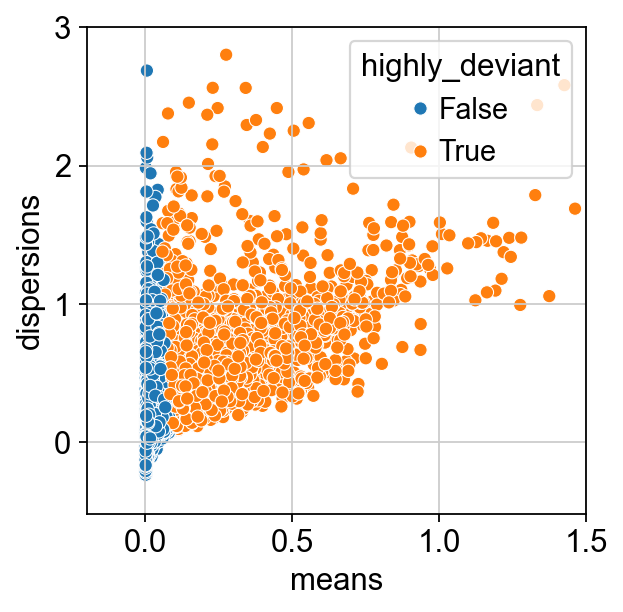

In [9]:
ax = sns.scatterplot(data=adata.var, x="means", y="dispersions", hue="highly_deviant")
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)

In [10]:
# higher mean expression indicated higher deviance so those genes are selected using this method
# (this is in line with empirical observations)

In [11]:
adata.write("s4d8_feature_selection.h5ad")